**Problem statement**

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

In [1]:
#importing libraries needed
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img
from glob import glob
#To avoid any warnings in the middle importing warnings
import warnings
warnings.filterwarnings('ignore')

**Connecting to google drive**

In [2]:
#mount google drive
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [3]:
#unzip the dataset
!unzip "/content/drive/MyDrive/CNN_assignment.zip" > /dev/null

A dataset contains 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

**Defining the path for train and test images** 

In [4]:
# Defining the path for train and test images
data_dir_train =pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

In [5]:
# Count the number of image in Train and Test directory
# Using the glob to retrieve files/pathnames matching a specified pattern.

#Train Image count
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

#Test Image count
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


**Create a Dataset**

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Using 80% of the images for training, and 20% for validation.

In [7]:
#Train datset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=batch_size,image_size=(img_height,img_width),label_mode='categorical',
                                                              seed=123,subset="training",validation_split=0.2)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
#Validation Dataset
val_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=batch_size,image_size=(img_height,img_width),label_mode='categorical',
                                                              seed=123,subset="validation",validation_split=0.2)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)
     

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


**Data Visulization**

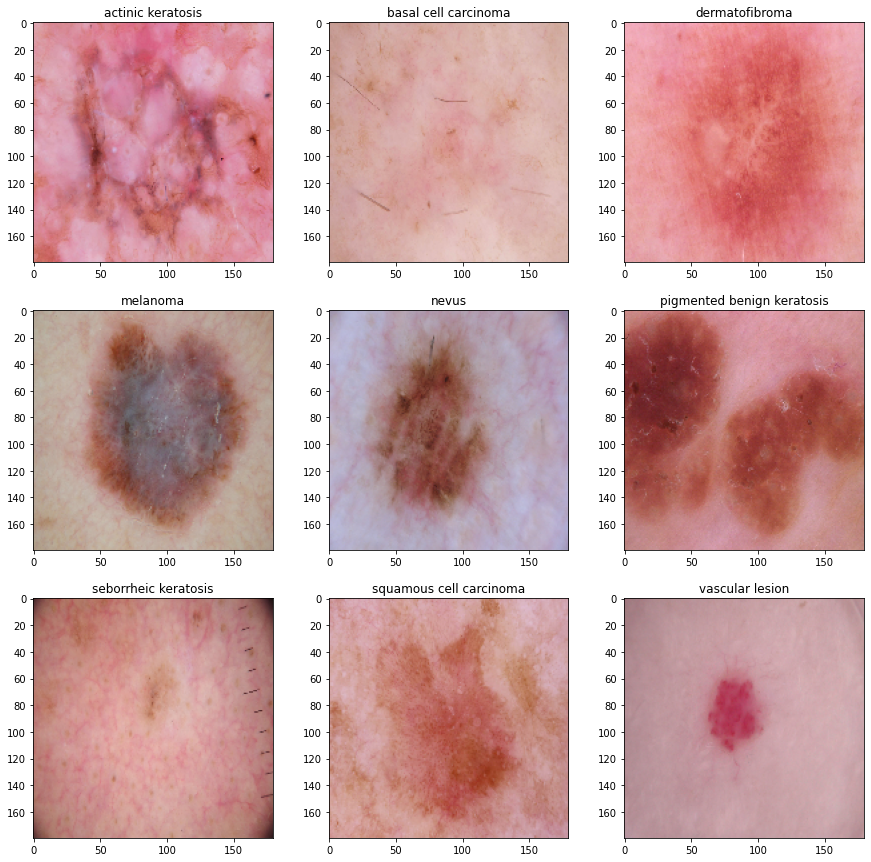

In [10]:
#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))
    
#Visualize image 
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(img_height,img_width)))
    plt.title(c)

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

**Create the model**

In [12]:
input_shape = (img_height,img_width,3)

model = Sequential()    #Sequential allows you to create models layer-by-layer  

#First Convulation Layer
model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=input_shape))
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Flatten())   #Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.

#Dense Layer
model.add(layers.Dense(512,activation='relu'))

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

**Compile the model** 

In [13]:
#Using Adam optimization technique
#categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.

model.compile(optimizer='Adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [14]:
# Getting summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

**Train the model**

In [15]:
#Using 20 epochs for model1
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 27s 87ms/step - loss: 1.9857 - accuracy: 0.2628 - val_loss: 1.7850 - val_accuracy: 0.3490
Epoch 2/20
56/56 [==============================] - 2s 39ms/step - loss: 1.6487 - accuracy: 0.3973 - val_loss: 1.5767 - val_accuracy: 0.4430
Epoch 3/20
56/56 [==============================] - 2s 39ms/step - loss: 1.4917 - accuracy: 0.4693 - val_loss: 1.5188 - val_accuracy: 0.5078
Epoch 4/20
56/56 [==============================] - 2s 38ms/step - loss: 1.4281 - accuracy: 0.4933 - val_loss: 1.4171 - val_accuracy: 0.5078
Epoch 5/20
56/56 [==============================] - 2s 38ms/step - loss: 1.3033 - accuracy: 0.5234 - val_loss: 1.4398 - val_accuracy: 0.4922
Epoch 6/20
56/56 [==============================] - 2s 38ms/step - loss: 1.2458 - accuracy: 0.5569 - val_loss: 1.5145 - val_accuracy: 0.4787
Epoch 7/20
56/56 [==============================] - 2s 38ms/step - loss: 1.2095 - accuracy: 0.5619 - val_loss: 1.2838 - val_accuracy: 0.5391
Epoch 8/20
5

**Visualizing training results**

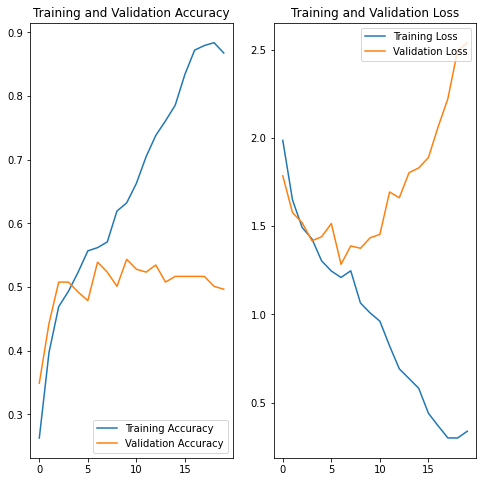

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Model is overfitting. From the above Training accuarcy vs Validation accuracy graph we can see that there is large difference between training and validation accuracy as the epoch increases.

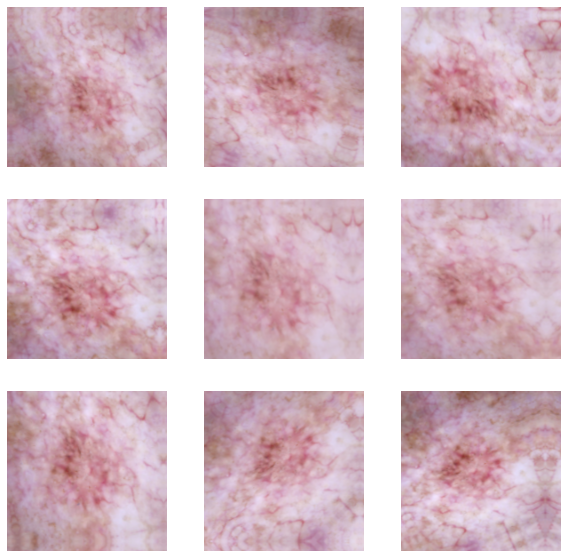

In [17]:
#Data augumentation
 #To rescale an input in the [0, 255] range to be in the [0, 1] range  
rescale = tf.keras.Sequential([
 layers.experimental.preprocessing.Rescaling(1./255)
])

data_augmentation = tf.keras.Sequential([
  #Randomly flip each images
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    
  #Randomly zoom each images during training
  layers.experimental.preprocessing.RandomZoom(0.2),

  #Randomly rotate each images
  layers.experimental.preprocessing.RandomRotation(0.2),
       
  #Randomly translate each images during training
  layers.experimental.preprocessing.RandomTranslation(0.1, 0.1),
  #Randomly contrast each images during training
  layers.experimental.preprocessing.RandomContrast(0.2)
])

#Visualize the augmentation image
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):   
    for i in range(9):
        augmented_images = data_augmentation(images)
        
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")    

**Model 2 Creation**

In [18]:
#Dropout layer: randomly sets input units to 0 with a frequency of rate at each step during training time,
#which helps prevent overfitting.Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged.


## Your code goes here
model2 = Sequential()                     #Sequential allows you to create models layer-by-layer  

model2.add(data_augmentation)             #Augmentation layer
model2.add(rescale)                       #Rescaling layer

#First Convulation Layer
model2.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model2.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 25% Fraction of the input units to drop.
model2.add(layers.Dropout(0.25))

#Second Convulation Layer
model2.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model2.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 25% Fraction of the input units to drop.
model2.add(layers.Dropout(0.25))

#Third Convulation Layer
model2.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model2.add(layers.MaxPool2D(pool_size=(2,2)))

#Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model2.add(layers.Flatten())

#Dense Layer
model2.add(layers.Dense(512,activation='relu'))

#Dense Layer
model2.add(layers.Dense(128,activation='relu'))

#Dropout layer with 50% Fraction of the input units to drop.
model2.add(layers.Dropout(0.50))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model2.add(layers.Dense(len(class_names),activation='softmax'))


**Compiling the model2**

In [19]:
model2.compile(optimizer='Adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

**Training the model2**

In [20]:
#Using 20 epochs for model2
epochs =20
history = model2.fit(train_ds,epochs=epochs,validation_data=val_ds,verbose=1)

Epoch 1/20


56/56 [==============================] - 32s 365ms/step - loss: 2.6366 - accuracy: 0.1775 - val_loss: 2.0864 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 21s 383ms/step - loss: 2.0490 - accuracy: 0.2137 - val_loss: 2.0787 - val_accuracy: 0.2081
Epoch 3/20
56/56 [==============================] - 20s 361ms/step - loss: 2.0502 - accuracy: 0.2003 - val_loss: 2.0261 - val_accuracy: 0.1991
Epoch 4/20
56/56 [==============================] - 22s 395ms/step - loss: 2.0503 - accuracy: 0.2009 - val_loss: 2.0789 - val_accuracy: 0.2058
Epoch 5/20
56/56 [==============================] - 22s 385ms/step - loss: 2.0322 - accuracy: 0.2171 - val_loss: 1.9970 - val_accuracy: 0.2416
Epoch 6/20
56/56 [==============================] - 22s 388ms/step - loss: 1.9872 - accuracy: 0.2439 - val_loss: 1.8376 - val_accuracy: 0.3669
Epoch 7/20
56/56 [==============================] - 20s 360ms/step - loss: 1.7825 - accuracy: 0.3482 - val_loss: 1.7424 - val_accuracy: 0.3400
Epoch 8/20

**Visualizing the results model2**

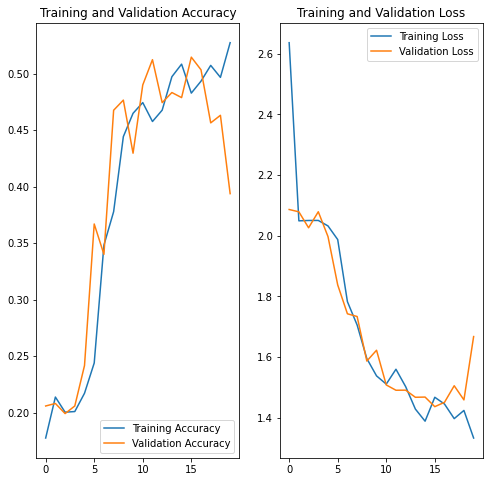

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

After performing data augumentation overfitting issue reduced.

Let's check is there any class imbalance is there

**Distribution of classes in the training dataset**

In [22]:
#count number of image in each classes
def class_distribution_count(dir_train):
       
    count= []
    for path in pathlib.Path(dir_train).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))
    
    #name of the classes
    sub_dir = [name for name in os.listdir(dir_train)
                    if os.path.isdir(os.path.join(dir_train, name))]
    
    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_dir,count)),columns =['Class', 'Number of Image'])

image_df = class_distribution_count(data_dir_train)
image_df

,Class,Number of Image
0,squamous cell carcinoma,181
1,melanoma,438
2,actinic keratosis,114
3,dermatofibroma,95
4,seborrheic keratosis,77
5,vascular lesion,139
6,nevus,357
7,pigmented benign keratosis,462
8,basal cell carcinoma,376


<AxesSubplot:xlabel='Number of Image', ylabel='Class'>

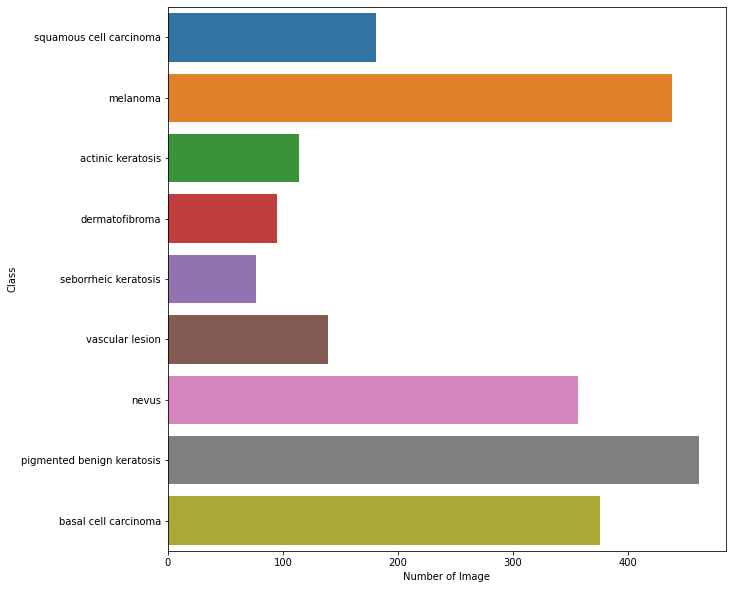

In [23]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 10))
sns.barplot(x="Number of Image", y="Class", data=image_df,
            label="Class")

pigmented benign keratosis(462 Samples) and melanoma (438 Samples) class has highest number of samples.

Seborrheic keratosis(77 Samples) has the least number of samples.



**Rectify the class imbalance**

**Context:** You can use a python package known as Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [24]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use Augmentor, the following general procedure is followed:

Instantiate a Pipeline object pointing to a directory containing your initial image data set.
Define a number of operations to perform on this data set using your Pipeline object.
Execute these operations by calling the Pipeline’s sample() method.

In [25]:
path_to_training_dataset="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F967116B0D0>: 100%|██████████| 500/500 [00:20<00:00, 24.77 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F96520A42B0>: 100%|██████████| 500/500 [00:25<00:00, 19.79 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9652370C10>: 100%|██████████| 500/500 [00:22<00:00, 21.84 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F96519CE7F0>: 100%|██████████| 500/500 [01:41<00:00,  4.91 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1504x1129 at 0x7F95C5309310>: 100%|██████████| 500/500 [01:15<00:00,  6.65 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F966C127BB0>: 100%|██████████| 500/500 [00:19<00:00, 25.63 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F95C5309310>: 100%|██████████| 500/500 [00:45<00:00, 11.05 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F95C5374C40>: 100%|██████████| 500/500 [00:18<00:00, 26.97 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F966C2120D0>: 100%|██████████| 500/500 [00:20<00:00, 24.74 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [26]:
#Count total number of image generated by using Augmentor
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


**Lets see the distribution of augmented data after adding new images to the original training data.**

In [27]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031929.jpg_b9d49cd8-d292-42f1-b15a-f6283d5062d5.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025712.jpg_eeff46b7-74fd-4ac3-83f2-ea9cd427dbb2.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0032154.jpg_67e6fb59-9319-4397-a2e8-0c0adcf46c79.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025637.jpg_4df451fa-747e-4f4a-9846-792ae5e388da.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0032356.jpg_2e072446-9c48-4373-b221-0525

In [28]:

lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carc

In [29]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [30]:
#dataframe that store path and label of the images generated by Augmentor
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

In [31]:
#label count.
df2['Label'].value_counts()

squamous cell carcinoma       500
melanoma                      500
actinic keratosis             500
dermatofibroma                500
seborrheic keratosis          500
vascular lesion               500
nevus                         500
pigmented benign keratosis    500
basal cell carcinoma          500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

**Train the model on the data created using Augmentor**


In [32]:
batch_size = 32
img_height = 180
img_width = 180

**Create a training dataset**

In [33]:
data_dir_train="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/" 

#Training dataset.
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,    #20% fraction of data to reserve for validation.
  subset = "training",
  image_size=(img_height, img_width),label_mode='categorical',  #label_mode='categorical' means that the labels are encoded as a categorical vector 
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


**Create a validation dataset**

In [34]:
#Validation dataset.
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),label_mode='categorical',   #label_mode='categorical' means that the labels are encoded as a categorical vector
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


**Create model3**


In [35]:
model3 = Sequential()

model3.add(rescale)   #Rescaling Layer

#First Convulation layer
model3.add(layers.Conv2D(32,kernel_size=(2,2),activation='relu'))
model3.add(layers.MaxPool2D(pool_size=(2,2)))
model3.add(layers.Dropout(0.25))

#Second Convulation Layer
model3.add(layers.Conv2D(64,kernel_size=(2,2),activation='relu'))
model3.add(layers.MaxPool2D(pool_size=(2,2)))
model3.add(layers.Dropout(0.25))

#Third Convulation Layer
model3.add(layers.Conv2D(128,kernel_size=(2,2),activation='relu'))
model3.add(layers.MaxPool2D(pool_size=(2,2)))

#Flatten Layer
model3.add(layers.Flatten())

#Dense Layer
model3.add(layers.Dense(512,activation='relu'))

#Dropout layer
model3.add(layers.Dropout(0.25))

#Batch normalization helps to make artificial neural networks faster and more stable through normalization 
#of the layers' inputs by re-centering and re-scaling.
model3.add(layers.BatchNormalization())

#Dense Layer
model3.add(layers.Dense(128,activation='relu'))

#Dropout layer with 50% Fraction of the input units to drop.
model3.add(layers.Dropout(0.50))

#Batch normalization
model3.add(layers.BatchNormalization())

#Dense layer with Softmax activation function.
model3.add(layers.Dense(len(class_names),activation='softmax'))


**Compile Model**

In [36]:
model3.compile(optimizer='Adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

**Train model**

In [37]:
#Using 30 epochs for model 3
epochs = 30
history = model3.fit(train_ds,epochs=epochs,validation_data=val_ds,verbose=1)

Epoch 1/30
169/169 [==============================] - 43s 229ms/step - loss: 2.4241 - accuracy: 0.1775 - val_loss: 3.6025 - val_accuracy: 0.1381
Epoch 2/30
169/169 [==============================] - 27s 158ms/step - loss: 1.8122 - accuracy: 0.3383 - val_loss: 2.3541 - val_accuracy: 0.2561
Epoch 3/30
169/169 [==============================] - 27s 157ms/step - loss: 1.5891 - accuracy: 0.4023 - val_loss: 1.8504 - val_accuracy: 0.3304
Epoch 4/30
169/169 [==============================] - 29s 165ms/step - loss: 1.4930 - accuracy: 0.4325 - val_loss: 1.5854 - val_accuracy: 0.3653
Epoch 5/30
169/169 [==============================] - 27s 156ms/step - loss: 1.3915 - accuracy: 0.4770 - val_loss: 1.5402 - val_accuracy: 0.3920
Epoch 6/30
169/169 [==============================] - 27s 158ms/step - loss: 1.3105 - accuracy: 0.5117 - val_loss: 1.6336 - val_accuracy: 0.3950
Epoch 7/30
169/169 [==============================] - 27s 157ms/step - loss: 1.2435 - accuracy: 0.5345 - val_loss: 1.3428 - val_ac

**Visualize the model results**

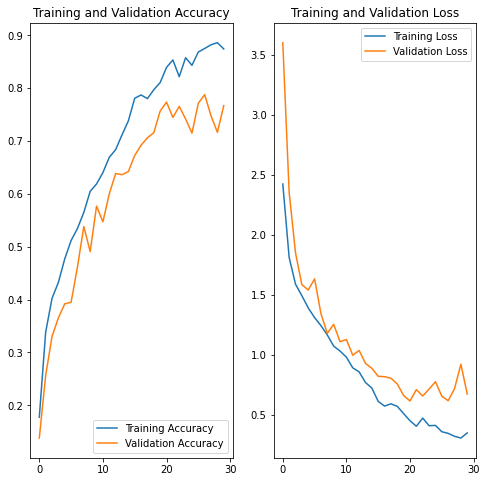

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Observations:**

As per the final model Training accuracy and validation accuracy increases.

Model overfitting issue is resolved.

Class rebalance helps in achieving the best Training and validation accuracy and augmentation.